# Gravitation constrained to a surface

Consider a point mass $m$ constrained to a surface in the 3-D space. The system is submitted to a uniform constant gravitation $g$ and moves without friction. For simplicity, we assume that the surface is stable by rotation around an axis $\Delta$ parallel to $g$. The referential is taken to be centred on a point $O$ of $\Delta$. Its $z$-axis is taken to be the semi-axis of $\Delta$ in the opposite direction to $g$. The $x$- and $y$-axes are chosen arbitrarily so as to form an orthogonal basis.

The generalised coordinates of the system are the angle $\phi$ ("azimuth") which is the polar coordinate of the projection of the point mass on the $x,y$-plane, and the angle $\theta$ ("zenith") which is the angle of the $z$-axis with the point mass. We have $0\leq\theta\leq\pi$, and any two $\theta,\phi$ identify a single point on the surface at radius $R(\theta)$. The coordinates of the point mass are then given by


\begin{equation*}
x = R\sin\theta\cos\phi
\hspace{2cm}
y = R\sin\theta\sin\phi
\hspace{2cm}
z = -R\cos\theta
\end{equation*}

The only active force is weight with coordinates $(0,0,-mg)$, hence of the form $-\nabla V$ with $V=mgz=-mgR\cos\theta$. Hence the Lagrangian

\begin{eqnarray*}
\mathcal{L} & = & m\left(\frac{1}{2}R^2\dot{\phi}^2\sin^2\theta+\frac{1}{2}(R^2+R'^2)\dot{\theta}^2+gR\cos\theta\right)
\end{eqnarray*}

Introducing the intermediary variable $\lambda=R^2\dot{\phi}\sin^2\theta$ (angular momentum), the equations of the dynamics are given by:

\begin{align*}
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{\phi}} = \frac{\partial\mathcal{L}}{\partial\phi}\right]
\hspace{1cm} &
\lambda=R^2\dot{\phi}\sin^2\theta
\hspace{1cm}
\dot{\lambda} = 0
\\
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{\theta}} = \frac{\partial\mathcal{L}}{\partial\theta}\right]
\hspace{1cm} &
\ddot{\theta} = \frac{1}{R^2+R'^2}\left(\frac{\lambda^2}{R^3\sin^3\theta}(R'\sin\theta+R\cos\theta)+g(R'\cos\theta-R\sin\theta)-R'(R+R'')\dot{\theta}^2\right)
\end{align*}

For a sphere, $R$ is independant of $\theta$ hence $R'=R''=0$ and, introducing $\Lambda\triangleq\frac{\lambda}{R^2}$, the system simplifies to

\begin{equation*}
\begin{array}{rcl}
\dot{\phi} & = & \frac{\Lambda}{\sin^2\theta}\\
\dot{\Lambda} & = & 0\\
\ddot{\theta} & = & \frac{\Lambda^2\cos\theta}{\sin^3\theta}-\frac{g}{R}\sin\theta
\end{array}
\end{equation*}

In [1]:
%pylab notebook
# for external animation (less resource consuming), use appropriate backend, e.g. qt5
import logging
from functools import partial
from ipyshow import Setup
from ipyshow.odesimu import System
from ipyshow.odesimu.util import logger_hook

Populating the interactive namespace from numpy and matplotlib


In [2]:
#----------------------------------------------------------------------------------------------------
class SphereSlider (System):
#----------------------------------------------------------------------------------------------------

  shadowshape = (5,)

  @Setup(
    'R: radius of the constraining sphere [m]',
    'G: intensity of the gravity [m.sec^-2]'
  )
  def __init__(self,R,G):
    from matplotlib.cm import get_cmap
    self.R, self.G = R, G
    def main(t,state,a=G/R):
      θ,θʹ,φ,Λ = state
      cosθ,sinθ = cos(θ),sin(θ)
      φʹ = Λ/square(sinθ)
      θʺ = (square(φʹ)*cosθ-a)*sinθ
      Λʹ = 0
      return array((θʹ,θʺ,φʹ,Λʹ))
    self.main = main
    def jac(t,state,a=G/R):
      θ,θʹ,φ,Λ = state
      cosθ,sinθ = cos(θ),sin(θ)
      s = 1/square(sinθ)
      v = 2*Λ*s*cosθ/sinθ
      return array(((0,1,0,0),(square(Λ)*s*(2-3*s)-a*cosθ,0,0,v),(-v,0,0,s),(0,0,0,0)))
    self.jacobian = jac
    def fordisplay(state,cmap=get_cmap('rainbow')):
      θ,θʹ,φ,Λ = state
      r = R*sin(θ)
      live = (r*cos(φ),r*sin(φ))+cmap((1-cos(θ))/2)[:-1]
      return live, live
    self.fordisplay = fordisplay

  def display(self,ax,refsize=None,**ka):
    from matplotlib.patches import Circle
    R = 1.05*self.R
    ax.set_xlim(-R,R)
    ax.set_ylim(-R,R)
    ax.scatter((0.,),(0.,),c='k',marker='o',s=refsize)
    ax.add_patch(Circle((0,0),self.R,edgecolor='k',facecolor='none'))
    diag_s = ax.scatter((),(),s=refsize,marker='o',c='r')
    tail_l, = ax.plot((),(),'gray')
    tail_s = ax.scatter((),(),s=refsize,marker='o')
    def disp(t,live,tail):
      x,y = live[:2]
      diag_s.set_offsets(((x,y),))
      diag_s.set_color(live[2:])
      tail_l.set_data(tail[:,0],tail[:,1])
      tail_s.set_offsets(tail[:,:2])
      tail_s.set_color(tail[:,2:])
    return super().display(ax,disp,**ka)

  @staticmethod
  @Setup(
    'θ: zenith [deg]',
    'θʹ: angular speed (zenith) [deg.sec^-1]',
    'φ: azimuth [deg]',
    'φʹ: angular speed (azimuth) [deg.sec^-1]',
    φ=0.,θʹ=0.,φʹ=0.
  )
  def makestate(θ,θʹ,φ,φʹ):
    s = square(sin(radians(θ)))
    return radians((θ,θʹ,φ,φʹ*s))

  @Setup(
    System.launch,
    'refsize: size (area) of the blob for display [pt^2]',
    taild=1.,refsize=50.,hooks=(partial(logger_hook,logger=logging.getLogger()),)
  )
  def launch(self,*a,**ka): return super().launch(*a,**ka)

In [3]:
Setup.display(SphereSlider)

**** SphereSlider.__init__(self, R, G) ****
    R         : radius of the constraining sphere [m]
    G         : intensity of the gravity [m.sec^-2]
**** SphereSlider.launch(self, *a, **ka) ****
    ini       : initial state []
    srate     (25.0      ): sampling rate [sec^-1]
    maxtime   (inf       ): total simulation time length [sec]
    taild     (1.0       ): shadow duration [sec]
    listeners : listener binding (events: start,stop,step,error) []
    hooks     ((functools): list of display hooks []
    refsize   (50.0      ): size (area) of the blob for display [pt^2]
**** SphereSlider.makestate(θ, θʹ, φ, φʹ) ****
    θ         : zenith [deg]
    θʹ        (0.0       ): angular speed (zenith) [deg.sec^-1]
    φ         (0.0       ): azimuth [deg]
    φʹ        (0.0       ): angular speed (azimuth) [deg.sec^-1]

<IPython.core.display.Javascript object>


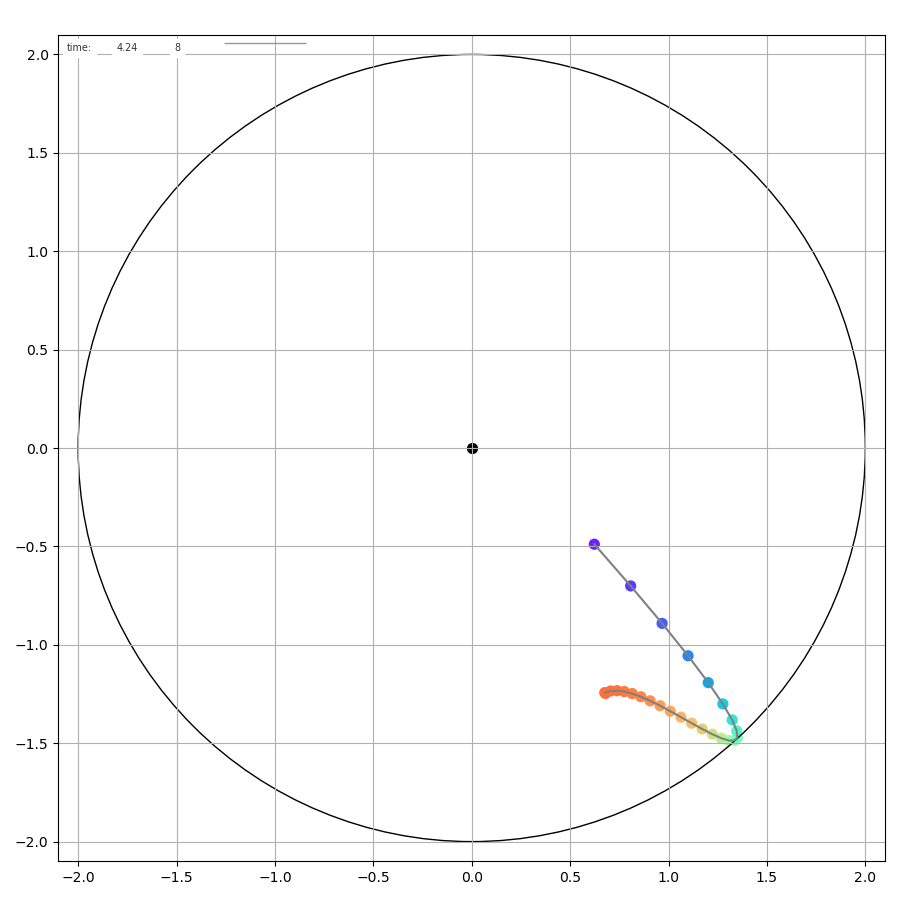

In [4]:
syst = SphereSlider(R=2.,G=9.81)
ini = dict(θ=135,θʹ=0,φʹ=-30)
syst.launch(ini=syst.makestate(**ini))